In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import argparse
import os
import shutil
import time
import random
import torch.nn.functional as F
from sklearn.metrics import precision_score,recall_score

from torch.utils.data import TensorDataset
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import tarfile
from sklearn.cluster import KMeans
from sklearn import datasets
import urllib
import errno
import torchmetrics
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler


In [3]:
def mkdir_p(path):
    '''make dir if not exist'''
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [4]:
#use_cuda = torch.cuda.is_available()


DATASET_PATH='./datasets/texas/'
DATASET_FEATURES = os.path.join(DATASET_PATH,'texas/100/feats')
DATASET_LABELS = os.path.join(DATASET_PATH,'texas/100/labels')

if not os.path.isdir(DATASET_PATH):
	mkdir_p(DATASET_PATH)

if not os.path.isfile(DATASET_FEATURES):
    print("Dowloading the dataset...")
    urllib.request.urlretrieve("https://www.comp.nus.edu.sg/~reza/files/dataset_texas.tgz",os.path.join(DATASET_PATH,'tmp.tgz'))
    print('Dataset Dowloaded')

    tar = tarfile.open(os.path.join(DATASET_PATH,'tmp.tgz'))
    tar.extractall(path=DATASET_PATH)


In [5]:
data_set_features =np.genfromtxt(DATASET_FEATURES,delimiter=',')
data_set_label =np.genfromtxt(DATASET_LABELS,delimiter=',')

X =data_set_features.astype(np.float64)
Y = data_set_label.astype(np.int32)-1

In [6]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].shape[0] == tensor.shape[0] for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        X = self.tensors[0][index]
        if self.transform is not None:
            X = self.transform(X)
        return X, tuple(self.tensors[i][index] for i in range(1, len(self.tensors)))
    
    def __len__(self):
        return self.tensors[0].shape[0]

In [7]:
clf_train_idx, clf_test_idx = train_test_split(
    np.arange(len(Y)), test_size=0.5, shuffle=True, stratify=Y
)
batch_size=128
train_sampler = sampler.SubsetRandomSampler(clf_train_idx)
test_sampler = sampler.SubsetRandomSampler(clf_test_idx)
#creating clf_train and clf_test dataloader

# Convert X to a torch tensor and Y to a torch tensor of type int64
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.int64)

# Creating clf_train and clf_test DataLoader using TensorDataset
clf_train_dl = DataLoader(TensorDataset(X_tensor, Y_tensor), batch_size=batch_size, sampler=train_sampler)
clf_test_dl = DataLoader(TensorDataset(X_tensor, Y_tensor), batch_size=batch_size, sampler=test_sampler)


#creating attacker dataset
y_true_atk = [t for t in Y]
y_atk = np.zeros(len(X), dtype=int)
y_atk[clf_train_idx.tolist()] = 1

atk_trainds = CustomTensorDataset(
    tensors=(X,torch.tensor(y_true_atk), torch.tensor(y_atk))
)
atk_train_idx, atk_test_idx = train_test_split(
    np.arange(len(atk_trainds.tensors[2].tolist())), test_size=0.2, shuffle=True, stratify=atk_trainds.tensors[2].tolist()
)
atk_train_sampler = sampler.SubsetRandomSampler(atk_train_idx)
atk_test_sampler = sampler.SubsetRandomSampler(atk_test_idx)

atk_train_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_train_sampler)
atk_test_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_test_sampler)


In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.layers = nn.Sequential(
           nn.Linear(6169,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.layers(x)

In [9]:
# Instantiate the model
model = FeatureExtractor()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 7532416


In [10]:
class TexasClassifier(nn.Module):
    def __init__(self):
        super(TexasClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(128, 100)
        )

    def forward(self, x):
        out = self.classifier(x)
        return out

In [11]:
# Instantiate the model

model =  TexasClassifier()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 12900


In [12]:
class TexasAttacker(nn.Module):
    def __init__(self):
        super(TexasAttacker, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        out = self.classifier(x)
        return out

In [15]:
# Instantiate the model

model =  TexasAttacker()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 66049


In [13]:

def adjust_learning_rate(epoch, init_lr=0.001):
    schedule = [12]
    cur_lr = init_lr
    for schedule_epoch in schedule:
        if epoch >= schedule_epoch:
            cur_lr *= 0.1
    return cur_lr

In [73]:
from torchmetrics import Accuracy
#pretraining FE+CF
criterion = nn.CrossEntropyLoss()
def train_FE_CF(FE, CF, data_train_loader, current_lr, vis=None):
    FE.train()
    CF.train()
    FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    acc = Accuracy().to(device)  # Add accuracy computation
    total_samples = 0
    correct_samples = 0
    for i, (images, labels) in enumerate(data_train_loader):
        if torch.cuda.is_available():
            #images, labels = images.cuda(), labels.cuda()
            images, labels = images.to(device), labels.to(device)


        features = FE(images)
        output_CF = CF(features)
        loss_CF = criterion(output_CF, labels)
        
        FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        FE_optimizer.step()

        # Update accuracy computation
        correct_samples += acc(output_CF, labels).item() * images.size(0)
        total_samples += images.size(0)

        if i % 100 == 0:
            current_accuracy = correct_samples / total_samples
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\tTraining Accuracy: {:.6f}'.format(
                i, i * len(images), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item(), current_accuracy))

    return FE, CF


In [74]:
test_clf_loss=[]  # list to store loss values
def eval_clf(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.to(device), y.to(device)
            features = fe(X)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            test_clf_loss.append(loss)  # add loss to list
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [75]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'Texas-100-3')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file = os.path.join(save_dir, 'FE.pth')
cf_model_file = os.path.join(save_dir, 'CF.pth')
inf_model_file=os.path.join(save_dir,'INF.pth')

In [78]:
total_epoch=1000
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device='cpu'
clf_criterion = nn.CrossEntropyLoss().to(device)
def get_FE_CF():
    FE = FeatureExtractor().to(device)
    CF = TexasClassifier().to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            FE = torch.nn.DataParallel(FE)
            CF = torch.nn.DataParallel(CF)
        #FE = FE.cuda()
        #CF = CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            FE, CF = train_FE_CF(FE, CF, clf_train_dl, current_lr, vis=None)
            #test_FE_CF2(FE, CF, clf_test_dl)
            eval_clf(FE,CF,clf_test_dl,clf_criterion,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(CF.module, "Models/mix/pre_train/CF.pth")
    else:
        torch.save(FE, fe_model_file)
        torch.save(CF, cf_model_file)

    return FE, CF

In [79]:
#overfitting on data
FE, CF = get_FE_CF()

epoch 0


Epoch: 0 [0/67330 (0%)]	Loss Classifier: 4.593935	Training Accuracy: 0.000000
Epoch: 100 [12800/67330 (38%)]	Loss Classifier: 3.982268	Training Accuracy: 0.038444
Epoch: 200 [25600/67330 (76%)]	Loss Classifier: 3.326020	Training Accuracy: 0.083178
Classifier Loss: 3.271711971723672 | Classifier Accuracy: 0.1683647632598877
epoch 1
Epoch: 0 [0/67330 (0%)]	Loss Classifier: 3.099349	Training Accuracy: 0.187500
Epoch: 100 [12800/67330 (38%)]	Loss Classifier: 2.613485	Training Accuracy: 0.265084
Epoch: 200 [25600/67330 (76%)]	Loss Classifier: 2.858646	Training Accuracy: 0.283738
Classifier Loss: 2.468528850512071 | Classifier Accuracy: 0.343086302280426
epoch 2
Epoch: 0 [0/67330 (0%)]	Loss Classifier: 2.128384	Training Accuracy: 0.367188
Epoch: 100 [12800/67330 (38%)]	Loss Classifier: 2.402795	Training Accuracy: 0.392327
Epoch: 200 [25600/67330 (76%)]	Loss Classifier: 2.228691	Training Accuracy: 0.409554
Classifier Loss: 2.119353623552756 | Classifier Accuracy: 0.43962571024894714
epoch 3
E

In [80]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad_(False) 
    model.eval()

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad_(True)
    model.train()

In [82]:
def get_precision_recall(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, predicted, average='macro',zero_division=0)
    recall = recall_score(labels, predicted, average='macro')
    return precision, recall

In [33]:
def add_noise_to_features(features, noise_level=0.01):
    """
    Add Gaussian noise to the features as a PyTorch tensor.

    Parameters:
    - features: The original features as a PyTorch tensor.
    - noise_level: Standard deviation of the Gaussian noise.
    
    Returns:
    - Noisy features as a PyTorch tensor.
    """
    # Ensure noise is generated on the same device as the features
    noise = torch.normal(0, noise_level, size=features.size(), device=features.device)
    return features + noise

In [83]:
#train pretrained FE+attacker
device = 'cuda' if torch.cuda.is_available() else 'cpu'
atk_criterion = nn.BCEWithLogitsLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_FE_INF(FE, INF, data_train_loader, current_lr,device, vis=None):
    INF.train()
    INF_optimizer = optim.Adam(INF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_INF = 0
    running_precision=0
    running_recall=0
    freeze(FE)
    for i,(X, (y1, y2)) in enumerate(atk_train_dl):
        #if torch.cuda.is_available():
        X, y1,y2= X.float().to(device), y1.float().to(device),y2.float().to(device)
        features = FE(X)
        #add guassian noise to the frozen features:
        #noisy_features=add_noise_to_features(features,0.01)
        # feed them to the inf model
        #pred_private_labels = INF(noisy_features)
        pred_private_labels = INF(features)
        y2 = y2.unsqueeze(1)
        loss_INF =atk_criterion(pred_private_labels,y2.float())
        precision, recall = get_precision_recall(pred_private_labels,y2)
        
        INF_optimizer.zero_grad()
        loss_INF.backward()
        INF_optimizer.step()
        

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss attacker: {:.6f}\t Precision attacker: {:.6f}\t recall attacler: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_INF.detach().item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return FE, INF

In [84]:
test_atk_loss=[]  # list to store loss values
def eval_atk(fe, INF, atk_test_dl, atk_criterion, device):
    fe.eval()
    INF.eval()
    acc=torchmetrics.Accuracy(task='binary').to(device)
    loss = []
    with torch.no_grad():
         for i, (X, (y1, y2)) in enumerate(atk_test_dl):
            X, y1,y2 = X.float().to(device), y1.to(device),y2.float().to(device)
            features = fe(X)
            atk_y = INF(features).squeeze()
            loss.append(atk_criterion(atk_y, y2).item())
            test_atk_loss.append(loss)  # add loss to list
            acc(atk_y, y2.long())
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [85]:
from timeit import default_timer as timer
total_epoch=200
lr=0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
atk_criterion = nn.BCEWithLogitsLoss().to(device)
def get_FE_INF():
    FE = torch.load(fe_model_file)
    INF = TexasAttacker()
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            start_time = timer()
            FE, INF = train_FE_INF(FE, INF, atk_train_dl, current_lr, device,vis=None)
            end_time = timer()
            print(f"Epoch took {end_time - start_time:.2f} seconds.")
            #test_FE_INF(FE, INF, atk_test_dl,device)
            eval_atk(FE,INF,atk_test_dl,atk_criterion,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(INF.module, "Models/mix/pre_train/CF.pth")
    else:
        #torch.save(FE, fe_model_file)
        torch.save(INF, inf_model_file)
    return FE, INF

In [86]:
FE, INF = get_FE_INF()

epoch 0


Epoch: 0 [0/67330 (0%)]	Loss attacker: 0.738739	 Precision attacker: 0.002305	 recall attacler: 0.005000	
Epoch: 100 [12800/67330 (24%)]	Loss attacker: 0.680151	 Precision attacker: 0.002422	 recall attacler: 0.005000	
Epoch: 200 [25600/67330 (48%)]	Loss attacker: 0.696955	 Precision attacker: 0.002383	 recall attacler: 0.005000	
Epoch: 300 [38400/67330 (71%)]	Loss attacker: 0.700638	 Precision attacker: 0.002617	 recall attacler: 0.005000	
Epoch: 400 [51200/67330 (95%)]	Loss attacker: 0.683343	 Precision attacker: 0.002578	 recall attacler: 0.005000	
Epoch took 7.18 seconds.
Classifier Loss: 0.6785180984802965 | Classifier Accuracy: 0.5092083811759949
epoch 1
Epoch: 0 [0/67330 (0%)]	Loss attacker: 0.662483	 Precision attacker: 0.002109	 recall attacler: 0.005000	
Epoch: 100 [12800/67330 (24%)]	Loss attacker: 0.659030	 Precision attacker: 0.002344	 recall attacler: 0.005000	
Epoch: 200 [25600/67330 (48%)]	Loss attacker: 0.674145	 Precision attacker: 0.002422	 recall attacler: 0.005000	

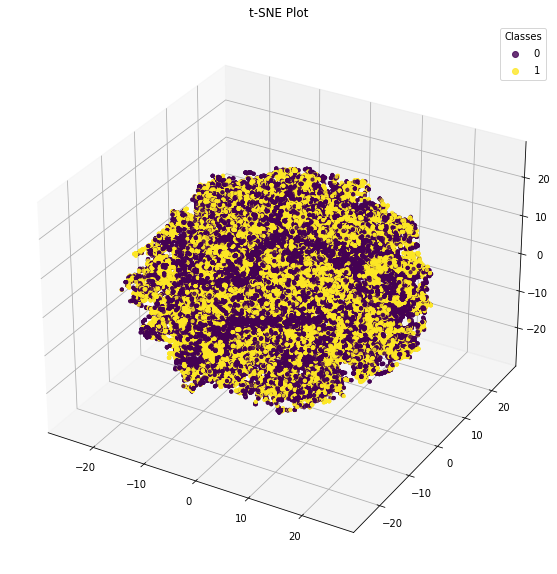

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from mpl_toolkits.mplot3d import Axes3D

# Extract features from the attacker's dataset
def extract_features(fe, data_loader, device, num_samples=1000):
    fe.eval()
    features = []
    labels = []

    # Flatten the data_loader into a list of (X, (y1, y2)) tuples
    data_list = [(X, (y1, y2)) for (X, (y1, y2)) in data_loader]
    
    # Randomly select num_samples samples from the list
    selected_data = random.choices(data_list, k=num_samples)

    with torch.no_grad():
        for i, (X, (y1, y2)) in enumerate(selected_data):
            X, y1, y2 = X.float().to(device), y1.float().to(device), y2.float().to(device)
            X_features = fe(X)
            features.append(X_features.cpu().numpy())
            labels.append(y2.cpu().numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)

    return features, labels

# Compute t-SNE embeddings
def compute_tsne(features, n_components=3, perplexity=30):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    embeddings = tsne.fit_transform(features)
    return embeddings

# Plot t-SNE embeddings
def plot_tsne(embeddings, labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='viridis', s=10, alpha=0.8)
    ax.legend(*scatter.legend_elements(), title="Classes")
    ax.set_title("t-SNE Plot")
    plt.show()
FE=torch.load(fe_model_file)
FE.to(device)
features, labels = extract_features(FE, atk_train_dl, device)
tsne_embeddings = compute_tsne(features)
plot_tsne(tsne_embeddings, labels)

In [87]:
criterion = nn.CrossEntropyLoss().cuda()
loss_fn = nn.BCEWithLogitsLoss().cuda()

def train(FE_model,INF_model, CF_model, trainloader, current_lr,current_lr_atk,tradoff=0.5):
    FE_model.train()
    INF_model.train()
    CF_model.train()
    #tradoff=0
    
    FE_optimizer = optim.Adam(FE_model.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF_model.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF_model.parameters(), lr=current_lr_atk, weight_decay=1e-4)
    
    for i, (images, (labels, privlabels)) in enumerate(trainloader):
        if torch.cuda.is_available():
            images, labels, privlabels = images.float().cuda(), labels.long().cuda(), privlabels.float().cuda()

        # get features from the feature extractor
        features = FE_model(images)
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())

        # feed only private images==1 to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        
        # compute loss and backprop
        loss = -tradoff * loss_INF + (1. - tradoff) * loss_CF
        
        FE_optimizer.zero_grad()
        loss.backward()
        FE_optimizer.step()

        
         # get features from the feature extractor
        features = FE_model(images).detach()
        INF_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())
        loss_INF.backward()
        INF_optimizer.step()

       
        # feed only private images to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        loss_CF.backward()
        CF_optimizer.step()

        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\tLoss Attacker: {:.6f}'.format(
                i, i * len(images), len(trainloader.dataset),
                100. * i / len(trainloader), loss_CF.item(), loss_INF.item()))

    return FE_model, INF_model, CF_model       

In [88]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'Texas-AfterDefense')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file_defense = os.path.join(save_dir, 'FE_defense.pth')
cf_model_file_defense = os.path.join(save_dir, 'CF_defense.pth')
inf_model_file_defense = os.path.join(save_dir, 'INF_defense.pth')

In [89]:
from timeit import default_timer as timer
total_epoch=2000
lr=0.0001
lr_atk=1e-4
tradoff=0.5
def get_FE_defense():
    FE = torch.load(fe_model_file)
    CF = torch.load(cf_model_file)
    INF=torch.load(inf_model_file)
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF = CF.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            current_lr_atk = adjust_learning_rate(epoch,lr_atk)
            start_time = timer()
            FE, INF, CF =train(FE,INF, CF, atk_train_dl, current_lr,current_lr_atk, tradoff)
            end_time = timer()
            print(f"Epoch took {end_time - start_time:.2f} seconds.")
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "FE_defense.pth")
        torch.save(CF.module, "CF_defense.pth")
        torch.save(INF.module, "INF_defense.pth")
    else:
        torch.save(FE,fe_model_file_defense)
        torch.save(INF,inf_model_file_defense)
        torch.save(CF, cf_model_file_defense)
    return FE

In [90]:
FE=get_FE_defense()

epoch 0


Epoch: 0 [0/67330 (0%)]	Loss Classifier: 0.020291	Loss Attacker: 0.811507
Epoch: 100 [12800/67330 (24%)]	Loss Classifier: 0.008003	Loss Attacker: 0.685778
Epoch: 200 [25600/67330 (48%)]	Loss Classifier: 0.006428	Loss Attacker: 0.669142
Epoch: 300 [38400/67330 (71%)]	Loss Classifier: 0.018093	Loss Attacker: 0.703206
Epoch: 400 [51200/67330 (95%)]	Loss Classifier: 0.040435	Loss Attacker: 0.701150
Epoch took 6.52 seconds.
epoch 1
Epoch: 0 [0/67330 (0%)]	Loss Classifier: 0.054583	Loss Attacker: 0.888421
Epoch: 100 [12800/67330 (24%)]	Loss Classifier: 0.017314	Loss Attacker: 0.669835
Epoch: 200 [25600/67330 (48%)]	Loss Classifier: 0.020267	Loss Attacker: 0.691656
Epoch: 300 [38400/67330 (71%)]	Loss Classifier: 0.030304	Loss Attacker: 0.721677
Epoch: 400 [51200/67330 (95%)]	Loss Classifier: 0.020179	Loss Attacker: 0.721668
Epoch took 6.26 seconds.
epoch 2
Epoch: 0 [0/67330 (0%)]	Loss Classifier: 0.018619	Loss Attacker: 0.848181
Epoch: 100 [12800/67330 (24%)]	Loss Classifier: 0.009956	Loss At

In [36]:
total_epoch=100
lr=0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_INF_defense():
    FE = torch.load(fe_model_file_defense)
    #INF= AlexNet_attacker()
    INF=torch.load(inf_model_file_defense)
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch,lr)
            FE, INF = train_FE_INF(FE, INF, atk_train_dl, current_lr, device,vis=None)
            #test_FE_INF(FE, INF, atk_test_dl,device)
            eval_atk(FE,INF,atk_test_dl,atk_criterion,device)
    except KeyboardInterrupt:
        pass

    return FE,INF

In [37]:
FE,INF = get_INF_defense()

epoch 0
Epoch: 0 [0/67330 (0%)]	Loss attacker: 0.692976	 Precision attacker: 0.002422	 recall attacler: 0.005000	
Epoch: 100 [12800/67330 (24%)]	Loss attacker: 0.693831	 Precision attacker: 0.002266	 recall attacler: 0.005000	
Epoch: 200 [25600/67330 (48%)]	Loss attacker: 0.693438	 Precision attacker: 0.002227	 recall attacler: 0.005000	
Epoch: 300 [38400/67330 (71%)]	Loss attacker: 0.692692	 Precision attacker: 0.002812	 recall attacler: 0.005000	
Epoch: 400 [51200/67330 (95%)]	Loss attacker: 0.693114	 Precision attacker: 0.002344	 recall attacler: 0.005000	
Classifier Loss: 0.693195917696323 | Classifier Accuracy: 0.5
epoch 1
Epoch: 0 [0/67330 (0%)]	Loss attacker: 0.693253	 Precision attacker: 0.002305	 recall attacler: 0.005000	
Epoch: 100 [12800/67330 (24%)]	Loss attacker: 0.693031	 Precision attacker: 0.002422	 recall attacler: 0.005000	
Epoch: 200 [25600/67330 (48%)]	Loss attacker: 0.693412	 Precision attacker: 0.002188	 recall attacler: 0.005000	
Epoch: 300 [38400/67330 (71%)]	L

In [38]:
#train classifier after applying our defense
clf_criterion = nn.CrossEntropyLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_classifier_defense(FE, CF, data_train_loader, current_lr,device, vis=None):
    CF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    running_precision=0
    running_recall=0
    #freezing the FE
    freeze(FE)
    for i,(X, y) in enumerate(clf_train_dl):
        #if torch.cuda.is_available():
        X, y= X.to(device), y.to(device)

        features = FE(X)
        # feed them to the inf model
        out_CF=CF(features)
        #pred_private_labels= torch.round(pred_private_labels)
        #y2=y2.float()
        #y = y.unsqueeze(1)
        loss_CF =clf_criterion(out_CF,y)
        #precision, recall = get_precision_recall(out_CF,y)
        #FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        #FE_optimizer.step()

        #running_precision+= precision
        #running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss classifier: {:.6f}\t Precision classifier: {:.6f}\t recall classifier: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return  CF

In [39]:
def eval_clf_defense(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.float().to(device), y.long().to(device)
            features = fe(X)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [40]:
total_epoch=100
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_clf_defense():
    FE = torch.load(fe_model_file_defense)
    #CF= AlexNet_predictor()
    CF=torch.load(cf_model_file_defense)
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF= CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            CF= train_classifier_defense(FE, CF, clf_train_dl, current_lr, device,vis=None)
            eval_clf_defense(FE, CF, clf_test_dl, clf_criterion, device)
    except KeyboardInterrupt:
        pass

    return CF

In [41]:
cf= get_clf_defense()

epoch 0
Epoch: 0 [0/67330 (0%)]	Loss classifier: 1.375178	 Precision classifier: 0.000000	 recall classifier: 0.000000	
Epoch: 100 [12800/67330 (38%)]	Loss classifier: 0.905785	 Precision classifier: 0.000000	 recall classifier: 0.000000	
Epoch: 200 [25600/67330 (76%)]	Loss classifier: 0.607971	 Precision classifier: 0.000000	 recall classifier: 0.000000	
Classifier Loss: 4.6033126635077775 | Classifier Accuracy: 0.5042328834533691
epoch 1
Epoch: 0 [0/67330 (0%)]	Loss classifier: 0.883337	 Precision classifier: 0.000000	 recall classifier: 0.000000	
Epoch: 100 [12800/67330 (38%)]	Loss classifier: 0.879264	 Precision classifier: 0.000000	 recall classifier: 0.000000	
Epoch: 200 [25600/67330 (76%)]	Loss classifier: 0.835376	 Precision classifier: 0.000000	 recall classifier: 0.000000	
Classifier Loss: 4.073863327503204 | Classifier Accuracy: 0.5042328834533691
epoch 2
Epoch: 0 [0/67330 (0%)]	Loss classifier: 0.704208	 Precision classifier: 0.000000	 recall classifier: 0.000000	
Epoch: 10

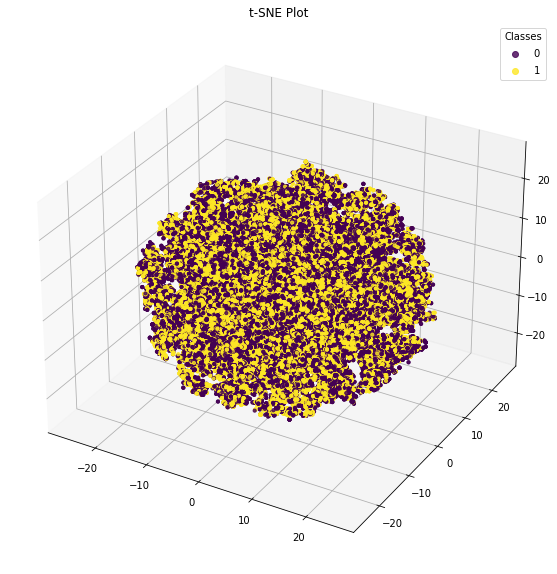

In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from mpl_toolkits.mplot3d import Axes3D

# Extract features from the attacker's dataset
def extract_features(fe, data_loader, device, num_samples=1000):
    fe.eval()
    features = []
    labels = []

    # Flatten the data_loader into a list of (X, (y1, y2)) tuples
    data_list = [(X, (y1, y2)) for (X, (y1, y2)) in data_loader]
    
    # Randomly select num_samples samples from the list
    selected_data = random.choices(data_list, k=num_samples)

    with torch.no_grad():
        for i, (X, (y1, y2)) in enumerate(selected_data):
            X, y1, y2 = X.float().to(device), y1.float().to(device), y2.float().to(device)
            X_features = fe(X)
            features.append(X_features.cpu().numpy())
            labels.append(y2.cpu().numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)

    return features, labels

# Compute t-SNE embeddings
def compute_tsne(features, n_components=3, perplexity=30):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    embeddings = tsne.fit_transform(features)
    return embeddings

# Plot t-SNE embeddings
def plot_tsne(embeddings, labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='viridis', s=10, alpha=0.8)
    ax.legend(*scatter.legend_elements(), title="Classes")
    ax.set_title("t-SNE Plot")
    plt.show()
FE=torch.load(fe_model_file_defense)
FE.to(device)
features, labels = extract_features(FE, atk_train_dl, device)
tsne_embeddings = compute_tsne(features)
plot_tsne(tsne_embeddings, labels)